# Using an SAE as a steering vector

This notebook demonstrates how to use SAE lens to identify a feature on a pretrained model, and then construct a steering vector to affect the models output to various prompts. This notebook will also make use of Neuronpedia for identifying features of interest.

The steps below include:



*   Installing relevant packages (Colab or locally)
*   Load your SAE and the model it used
*   Determining your feature of interest and its index
*   Implementing your steering vector





## Setting up packages and notebook

### Import and installs

#### Environment Setup


In [190]:
try:
  # for google colab users
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
  # for local setup
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading
PORT = 8000

# general imports
import os
import torch
from tqdm import tqdm
import plotly.express as px

torch.set_grad_enabled(False);

import pandas as pd
import itertools as ittl
import numpy as np
from scipy import stats
import seaborn as sns
from datasets import load_dataset
import transformers


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### General Installs and device setup

In [2]:
# package import
from torch import Tensor
from transformer_lens import utils
from functools import partial
from jaxtyping import Int, Float


# device setup
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


### Load your model and SAE

We're going to work with a pretrained GPT2-small model, and the RES-JB SAE set which is for the residual stream.

In [3]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 2

# get model
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

# get the SAE for this layer
'''
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = device
)
'''
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_pre",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
blocks.2.hook_resid_pre


## Determine your feature of interest and its index

### Find your feature

#### Explore through code by using the feature activations for a prompt

For the purpose of the tutorial, we are selecting a simple token prompt.

In this example we will look trying to find and steer a "Jedi" feature.

We run our prompt on our model and get the cache, which we then use with our sae to get our feature activations.

Now we'll look at the top feature activations and look them up on Neuronpedia to determine what they have been intepreted as.

In [4]:
print('dir(sae)\n', dir(sae))
print('sae.W_enc.shape\n', sae.W_enc.shape)

print('\n')

#sv_prompt = " The Golden Gate Bridge"
# sv_prompt = 'Jedi'
sv_prompt = 'Emily\'s dog just died. She is feeling sad'
# sv_prompt = 'John\'s lunch was stolen. He is feeling angry'
# sv_prompt = 'John just received a present. He is feeling happy'

sv_logits, cache = model.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model.to_tokens(sv_prompt)
print('tokens', tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

# print out the top activations, focus on the indices
print('\n', torch.topk(sv_feature_acts, 3))


# Explanation of the topk outputs below:
# There are 5 tokens in sv_prompt: <BOS>, The, Golden, Gate, Bridge. 
# So what topk is showing is for each token what SAE feature is being activated the most.
# Thats why we have a 5 x 3 array. 


dir(sae)
 ['T_destination', 'W_dec', 'W_enc', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_enable_hook', '_enable_hook_with_name', '_enable_hooks_for_points', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', 

### Set up hook functions

Finally, we need to create a hook that allows us to apply the steering vector when our model runs generate() on our defined prompt. We have also added a boolean value 'steering_on' that allows us to easily toggle the steering vector on and off for each prompt


In [5]:
def steering_hook(resid_pre, hook):

    if resid_pre.shape[1] == 1:
        return

    # print('resid_pre.shape', resid_pre.shape)
    position = sae.W_dec.shape[-1]
    # print('sae_out.shape', sae_out.shape, '\n')
    if steering_on:
      # using our steering vector and applying the coefficient

      # So here resid_pre are the values from the residual stream (in this case [batch_size, n_tokens, 768])
      # We modify all values up to but not including the last token (since its an EOS token)

      # Modification is an addition of the outgoing weights from the target SAE feature 
      # (which is a size 768 vector) multiplied by a coefficient that controls the magnitude of the steering

      # The steered values would then make their way through the rest of the model
      resid_pre[:, :position - 1, :] += coeff * steering_vector

def ablation_hook(resid_pre, hook):

    if resid_pre.shape[1] == 1:
        return

    position = sae.W_dec.shape[-1]
    
    act_strength = (resid_pre @ sae.W_enc)[:, :position-1, feature_id]
    act_strength = torch.unsqueeze(act_strength, -1)
    new_shape = list(act_strength.shape)
    new_shape[-1] = steering_vector.shape[-1]
    act_strength.expand(new_shape)
    
    if steering_on:
        resid_pre[:, :position-1, :] -= act_strength * steering_vector

def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=30,
            do_sample=True,
            **kwargs)
    return result


In [6]:
def run_generate(prompts, n_samples, steering_type='steer'):
  
  res_list = []

  for prompt, label in prompts:

    model.reset_hooks()

    # Steering
    editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)] if steering_type == 'steer' \
                    else [(f"blocks.{layer}.hook_resid_post", ablation_hook)]

    res = hooked_generate([prompt] * n_samples, editing_hooks, seed=None, **sampling_kwargs)

    # Print results, removing the ugly beginning of sequence token
    res_str = model.to_string(res[:, 1:])
    res_str = [(text.split('\". '))[1] for text in res_str]
    res_list.append({'prompt': prompt, 'responses': res_str, 'label': label})

  return pd.DataFrame(res_list)

## Implement your steering vector and affect the output

### Define values for your steering vector
To create our steering vector, we now need to get the decoder weights from our sparse autoencoder found at our index of interest.

Then to use our steering vector, we want a prompt for text generation, as well as a scaling factor coefficent to apply with the steering vector

We also set common sampling kwargs - temperature, top_p and freq_penalty

In [7]:
# Golden State Bridge:
# steering_vector = sae.W_dec[10200]

# Jedi:
# steering_vector = sae.W_dec[7650]

# Sadness: 2442, 
# steering_vector = sae.W_dec[2442]

# Anger: 1550, 4707, 18357, 5526, 21165, 252
# steering_vector = sae.W_dec[21165]

# Worry: 849, 15524, 18978, 21673
# steering_vector = sae.W_dec[18978]

# Happiness: 13928, 3879, 3456
# steering_vector = sae.W_dec[24422]
# sampling_kwargs = dict(temperature=0.9, top_p=0.1, freq_penalty=1.0)

### Loading an Emotion Recognition Dataset - https://github.com/dair-ai/emotion_dataset

In [8]:
emotion_dataset = load_dataset('dair-ai/emotion', split='train', trust_remote_code=True)


In [164]:
emotion_dataset = emotion_dataset.shuffle()
batch_size = 16
batch = emotion_dataset[:batch_size]
print(batch)

{'text': ['i feel funny just calling it a film', 'i feel that everyone is entitiled to their opinion and that opinion should be respected', 'i love the treadmill and i am actually so used to it that i actually feel intimidated running outside', 'i was really surprised by how much i like this moisturizer it smells really good and feels amazing on the skin', 'i feel utterly devastated that she must go through this and do so alone', 'i went to sleep friday i was feeling relieved that none of our family was caught in the tornadoes in broken arrow later that night', 'i hear the word and i feel stronger and re assured once again', 'i dont even know how to describe how i feel its like im sad but i can understand his decision but i cant control myself to not be mad at him', 'i feel like the rest of the season will continue to be successful like we were at freestone', 'i was feeling optimistic and actually ran the first couple miles at probably a pace', 'i feel agitated thinking about his mothe

In [165]:
prompts = [f'John says, \"{text}\". John feels' for text in batch['text']]
labels = [label for label in batch['label']]
prompts = list(zip(prompts, labels))

### Getting a "judge" model to judge the generations

### Alternative Judge Model (Finetuned DISTILBERT)

In [11]:
# bert_judge = transformers.pipeline(model='ActivationAI/distilbert-base-uncased-finetuned-emotion', device=0)

/home/jovyan/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
%reset_selective -f bert_judge

In [166]:
print(prompts)

# Because of the variance that comes with generations, we gotta run many iterations for each feature for EACH coefficient value.
n_samples = 16
# layer 2 - anger: 11085, 19854, 21027, 14918, 252, 21165, 4707, 1550, 5526, 18357
# layer 2 - love: 3203
# layer 2 - sadness: 11683, 14915, 17722, 11568, 4350, 2442, 10636
feature_id = 22134
steering_vector = sae.W_dec[feature_id]
steer_type = 'steer'
coeff = 15
sampling_kwargs = dict(temperature=0.5, top_p=0.1, freq_penalty=1.0)

steering_on = True
steered_generation = run_generate(prompts, n_samples, steering_type=steer_type)

steering_on = False
default_generation = run_generate(prompts, n_samples, steering_type=steer_type)

[('John says, "i feel funny just calling it a film". John feels', 5), ('John says, "i feel that everyone is entitiled to their opinion and that opinion should be respected". John feels', 1), ('John says, "i love the treadmill and i am actually so used to it that i actually feel intimidated running outside". John feels', 4), ('John says, "i was really surprised by how much i like this moisturizer it smells really good and feels amazing on the skin". John feels', 1), ('John says, "i feel utterly devastated that she must go through this and do so alone". John feels', 0), ('John says, "i went to sleep friday i was feeling relieved that none of our family was caught in the tornadoes in broken arrow later that night". John feels', 1), ('John says, "i hear the word and i feel stronger and re assured once again". John feels', 1), ('John says, "i dont even know how to describe how i feel its like im sad but i can understand his decision but i cant control myself to not be mad at him". John feel

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [84]:
steered_example = steered_generation.iloc[0]['responses']
default_example = default_generation.iloc[0]['responses']


In [ ]:

steered_judgments = bert_judge(steered_example, top_k=None)
default_judgments = bert_judge(default_example, top_k=None)

In [98]:
print(steered_judgments)

[[{'label': 'LABEL_1', 'score': 0.9571658372879028}, {'label': 'LABEL_2', 'score': 0.020777974277734756}, {'label': 'LABEL_0', 'score': 0.010290060192346573}, {'label': 'LABEL_5', 'score': 0.0057431370951235294}, {'label': 'LABEL_3', 'score': 0.003165498608723283}, {'label': 'LABEL_4', 'score': 0.002857564715668559}], [{'label': 'LABEL_1', 'score': 0.9571658372879028}, {'label': 'LABEL_2', 'score': 0.020777974277734756}, {'label': 'LABEL_0', 'score': 0.010290060192346573}, {'label': 'LABEL_5', 'score': 0.0057431370951235294}, {'label': 'LABEL_3', 'score': 0.003165498608723283}, {'label': 'LABEL_4', 'score': 0.002857564715668559}], [{'label': 'LABEL_1', 'score': 0.9571658372879028}, {'label': 'LABEL_2', 'score': 0.020777974277734756}, {'label': 'LABEL_0', 'score': 0.010290060192346573}, {'label': 'LABEL_5', 'score': 0.0057431370951235294}, {'label': 'LABEL_3', 'score': 0.003165498608723283}, {'label': 'LABEL_4', 'score': 0.002857564715668559}], [{'label': 'LABEL_1', 'score': 0.957165837

In [99]:
# Organize the label, score pairs. Average across labels scores
labels = emotion_dataset.features['label'].names

def get_label_score_stats(results):

    stats = {f'LABEL_{x}' : np.empty(n_samples) for x in range(len(labels))}
    for index, item in enumerate(results):
        for d in item:
            stats[d['label']][index] = d['score']
    
    # Average
    avgs = {x: stats[x].mean(axis=0) for x in stats}
    # SD
    sds = {x: stats[x].std(axis=0) for x in stats}
    
    return avgs, sds

In [100]:
steered_avgs, steered_sds = get_label_score_stats(steered_judgments)
default_avgs, default_sds = get_label_score_stats(default_judgments)

In [101]:
print('Steered averages:')
print(steered_avgs)
print('\n', '-'*100, '\n')

print('Steered std devs:')
print(steered_sds)
print('\n', '-'*100, '\n')

print('Default averages:')
print(default_avgs)
print('\n', '-'*100, '\n')

print('Default std devs:')
print(default_sds)


Steered averages:
{'LABEL_0': 0.010290060192346573, 'LABEL_1': 0.9571658372879028, 'LABEL_2': 0.020777974277734756, 'LABEL_3': 0.003165498608723283, 'LABEL_4': 0.002857564715668559, 'LABEL_5': 0.0057431370951235294}

 ---------------------------------------------------------------------------------------------------- 

Steered std devs:
{'LABEL_0': 0.0, 'LABEL_1': 0.0, 'LABEL_2': 0.0, 'LABEL_3': 0.0, 'LABEL_4': 0.0, 'LABEL_5': 0.0}

 ---------------------------------------------------------------------------------------------------- 

Default averages:
{'LABEL_0': 0.005845827050507069, 'LABEL_1': 0.9444676041603088, 'LABEL_2': 0.03586956113576889, 'LABEL_3': 0.0035950413439422846, 'LABEL_4': 0.00338013656437397, 'LABEL_5': 0.006841719150543213}

 ---------------------------------------------------------------------------------------------------- 

Default std devs:
{'LABEL_0': 0.0, 'LABEL_1': 0.0, 'LABEL_2': 0.0, 'LABEL_3': 0.0, 'LABEL_4': 0.0, 'LABEL_5': 0.0}


### Results for example prompt: [('John says, "i feel useless and worthless". John feels', 0)]. Different coeff values for love related feature: 3203

10 
{'LABEL_0': 0.7190215387940406, 'LABEL_1': 0.06529127676971257, 'LABEL_2': 0.012774634957313537, 'LABEL_3': 0.170976769994013, 'LABEL_4': 0.025992137745488433, 'LABEL_5': 0.005943622009363025}
{'LABEL_0': 0.6026774962991476, 'LABEL_1': 0.2198826998565346, 'LABEL_2': 0.03258214028785005, 'LABEL_3': 0.09322445983532816, 'LABEL_4': 0.03770605735480785, 'LABEL_5': 0.013927115728147327}

20
{'LABEL_0': 0.2767638837033883, 'LABEL_1': 0.48788393307011574, 'LABEL_2': 0.12167917459039018, 'LABEL_3': 0.08963876160560176, 'LABEL_4': 0.011855096041690558, 'LABEL_5': 0.012179144371766598}
{'LABEL_0': 0.5145439236052334, 'LABEL_1': 0.25482457326259467, 'LABEL_2': 0.037844830222893505, 'LABEL_3': 0.12796071587130428, 'LABEL_4': 0.04867495798505843, 'LABEL_5': 0.016150978496298193}

21
{'LABEL_0': 0.22872907536104323, 'LABEL_1': 0.6059607860352844, 'LABEL_2': 0.09070620632264763, 'LABEL_3': 0.05344671495491639, 'LABEL_4': 0.009989762811455876, 'LABEL_5': 0.011167455443646758}
{'LABEL_0': 0.5534170390106737, 'LABEL_1': 0.2607078705215827, 'LABEL_2': 0.039753439133055506, 'LABEL_3': 0.07759478480089456, 'LABEL_4': 0.051232845042832195, 'LABEL_5': 0.01729399512754753}

22
{'LABEL_0': 0.3396644503204152, 'LABEL_1': 0.4476533314073458, 'LABEL_2': 0.08580599198816344, 'LABEL_3': 0.09983911606250331, 'LABEL_4': 0.018257545738015322, 'LABEL_5': 0.008779570928309112}
{'LABEL_0': 0.5665904127806425, 'LABEL_1': 0.24354308717884124, 'LABEL_2': 0.04210721633862704, 'LABEL_3': 0.07187060184776783, 'LABEL_4': 0.05738185498397797, 'LABEL_5': 0.01850679338676855}

23
{'LABEL_0': 0.1237382231745869, 'LABEL_1': 0.3527423197031021, 'LABEL_2': 0.4779345570830628, 'LABEL_3': 0.02958498215302825, 'LABEL_4': 0.006788506475277245, 'LABEL_5': 0.009211436281912028}
{'LABEL_0': 0.5876903250813484, 'LABEL_1': 0.2559698004135862, 'LABEL_2': 0.035816639598924664, 'LABEL_3': 0.07495108143892139, 'LABEL_4': 0.0323313411232084, 'LABEL_5': 0.01324078136589378}

24
{'LABEL_0': 0.007485882248729468, 'LABEL_1': 0.03183951780200005, 'LABEL_2': 0.936437451839447, 'LABEL_3': 0.007265836913138628, 'LABEL_4': 0.006901567005552351, 'LABEL_5': 0.010069809835404158}
{'LABEL_0': 0.6413067180477082, 'LABEL_1': 0.21493106715846808, 'LABEL_2': 0.03362984130391851, 'LABEL_3': 0.057936261557042595, 'LABEL_4': 0.03838124629110098, 'LABEL_5': 0.013814834321383387}

25
{'LABEL_0': 0.007720328494906425, 'LABEL_1': 0.03175815533846617, 'LABEL_2': 0.9361573082208633, 'LABEL_3': 0.007508245576173067, 'LABEL_4': 0.00690976888872683, 'LABEL_5': 0.009946258990094065}
{'LABEL_0': 0.6295325769297778, 'LABEL_1': 0.22658848601859063, 'LABEL_2': 0.034671142033766957, 'LABEL_3': 0.057508688583038745, 'LABEL_4': 0.03712139300536364, 'LABEL_5': 0.014577674837782979}

26
{'LABEL_0': 0.007385426070541144, 'LABEL_1': 0.03382726266980171, 'LABEL_2': 0.9346040987968445, 'LABEL_3': 0.007178835496306419, 'LABEL_4': 0.006936507765203714, 'LABEL_5': 0.010067825168371201}
{'LABEL_0': 0.5798048145137727, 'LABEL_1': 0.20833267248701304, 'LABEL_2': 0.034663620891515166, 'LABEL_3': 0.11104273302480579, 'LABEL_4': 0.050000698533840475, 'LABEL_5': 0.016155425736214965}

27
{'LABEL_0': 0.007386308098211884, 'LABEL_1': 0.03378420170396566, 'LABEL_2': 0.9346386295557022, 'LABEL_3': 0.007189592774957418, 'LABEL_4': 0.0069324125070124865, 'LABEL_5': 0.010068810991942883}
{'LABEL_0': 0.6329669214971364, 'LABEL_1': 0.19393649023026227, 'LABEL_2': 0.0316765616228804, 'LABEL_3': 0.08724732583388686, 'LABEL_4': 0.04069230439607054, 'LABEL_5': 0.01348036871990189}

28
{'LABEL_0': 0.008011017292737961, 'LABEL_1': 0.05707123450934887, 'LABEL_2': 0.9088250136375428, 'LABEL_3': 0.007588768661953509, 'LABEL_4': 0.007288112775422633, 'LABEL_5': 0.011215808372944593}
{'LABEL_0': 0.6438233935460448, 'LABEL_1': 0.16344862488098444, 'LABEL_2': 0.02961703544249758, 'LABEL_3': 0.10635165481828153, 'LABEL_4': 0.04349331659730524, 'LABEL_5': 0.013265945259481668}

29
{'LABEL_0': 0.007735552247613669, 'LABEL_1': 0.05787921670824289, 'LABEL_2': 0.9090993529558182, 'LABEL_3': 0.00719900889787823, 'LABEL_4': 0.007003822838887572, 'LABEL_5': 0.011083016032353043}
{'LABEL_0': 0.6189842127636075, 'LABEL_1': 0.19435476975515484, 'LABEL_2': 0.03166778691578656, 'LABEL_3': 0.09701234207954258, 'LABEL_4': 0.043578346725553274, 'LABEL_5': 0.014402509992942214}

30 
{'LABEL_0': 0.008448598813265562, 'LABEL_1': 0.06381071772426367, 'LABEL_2': 0.9007281023263931, 'LABEL_3': 0.0077571926591917875, 'LABEL_4': 0.0076361627783626315, 'LABEL_5': 0.011619238900020718}
{'LABEL_0': 0.6021977141499519, 'LABEL_1': 0.2036181228933856, 'LABEL_2': 0.03108630757080391, 'LABEL_3': 0.1087468426534906, 'LABEL_4': 0.04018298890441656, 'LABEL_5': 0.014167988928966225}

100
{'LABEL_0': 0.010502127935178579, 'LABEL_1': 0.07553076501935721, 'LABEL_2': 0.8890670169517398, 'LABEL_3': 0.007208804409019649, 'LABEL_4': 0.007873942507430912, 'LABEL_5': 0.009817339479923248}
{'LABEL_0': 0.5515771327912807, 'LABEL_1': 0.22069891304709016, 'LABEL_2': 0.037646842554677276, 'LABEL_3': 0.11671273810788989, 'LABEL_4': 0.05584903904236853, 'LABEL_5': 0.0175153036811389}


### Results for example prompt: [('John says, "i feel useless and worthless". John feels', 0)]. Ablating different sadness related features.

11683
{'LABEL_0': 0.7438570696860551, 'LABEL_1': 0.18644340730272232, 'LABEL_2': 0.0247323771356605, 'LABEL_3': 0.017631164686754346, 'LABEL_4': 0.01756741581019014, 'LABEL_5': 0.009768533073365688}
{'LABEL_0': 0.6161106714047492, 'LABEL_1': 0.18169188546482473, 'LABEL_2': 0.028732943083159625, 'LABEL_3': 0.12216368986293674, 'LABEL_4': 0.038217867156490684, 'LABEL_5': 0.01308290582615882}

14915
{'LABEL_0': 0.008139210753142834, 'LABEL_1': 0.949044406414032, 'LABEL_2': 0.03130289167165756, 'LABEL_3': 0.00414611678570509, 'LABEL_4': 0.0027581765316426754, 'LABEL_5': 0.00460908655077219}
{'LABEL_0': 0.5758281467668712, 'LABEL_1': 0.2030424150498584, 'LABEL_2': 0.03302797882817685, 'LABEL_3': 0.1272725001210347, 'LABEL_4': 0.04610442724544555, 'LABEL_5': 0.014724502684548496}

17722
{'LABEL_0': 0.2885161219164729, 'LABEL_1': 0.46399708884768187, 'LABEL_2': 0.028879764513112603, 'LABEL_3': 0.16316900093108416, 'LABEL_4': 0.03944069048855454, 'LABEL_5': 0.015997369014658033}
{'LABEL_0': 0.6763336971402168, 'LABEL_1': 0.17796218468341976, 'LABEL_2': 0.02843470806023106, 'LABEL_3': 0.06912240616977215, 'LABEL_4': 0.03557066047098487, 'LABEL_5': 0.012576312185265124}

11568
{'LABEL_0': 0.48621975720860067, 'LABEL_1': 0.4106632198439911, 'LABEL_2': 0.031068368107080458, 'LABEL_3': 0.020184251200407743, 'LABEL_4': 0.03600713633466512, 'LABEL_5': 0.01585724333766848}
{'LABEL_0': 0.5652943521365523, 'LABEL_1': 0.226593662253581, 'LABEL_2': 0.03588325154967606, 'LABEL_3': 0.11619068092200906, 'LABEL_4': 0.041884939451701936, 'LABEL_5': 0.014153092394117266}

4350
{'LABEL_0': 0.9730195999145508, 'LABEL_1': 0.008994914591312408, 'LABEL_2': 0.004097764380276203, 'LABEL_3': 0.007663421798497438, 'LABEL_4': 0.0038471869193017483, 'LABEL_5': 0.002377139637246728}
{'LABEL_0': 0.6374521311931312, 'LABEL_1': 0.2146033818181604, 'LABEL_2': 0.034242681413888934, 'LABEL_3': 0.05548086636234075, 'LABEL_4': 0.043121416876092555, 'LABEL_5': 0.015099486615508795}

2442
{'LABEL_0': 0.6811704892665148, 'LABEL_1': 0.22660987806506455, 'LABEL_2': 0.026250735172070563, 'LABEL_3': 0.026648959834128617, 'LABEL_4': 0.028745932737365365, 'LABEL_5': 0.010574012834113092}
{'LABEL_0': 0.5984470611251891, 'LABEL_1': 0.21912903918419033, 'LABEL_2': 0.03872540342854336, 'LABEL_3': 0.07174572517164052, 'LABEL_4': 0.054375935890711845, 'LABEL_5': 0.017576801620889454}

10636
{'LABEL_0': 0.09680476065259427, 'LABEL_1': 0.8577145149558782, 'LABEL_2': 0.0314618837274611, 'LABEL_3': 0.005863760388456285, 'LABEL_4': 0.0032979709561914206, 'LABEL_5': 0.004857047218829394}
{'LABEL_0': 0.5427213779650628, 'LABEL_1': 0.2272636397043243, 'LABEL_2': 0.04191851173061877, 'LABEL_3': 0.10166165309492499, 'LABEL_4': 0.06627334529999644, 'LABEL_5': 0.020161441655363887}

## Next Steps

Ideas you could take for further exploration:

*   Try ablating the feature
*   Try and get a response where just the feature token prints over and over
*   Investigate other features with more complex usage



### Effect of ablating emotion related features

### Attempts at LLMs as Oracles

In [167]:
emotion_labels = emotion_dataset.features['label'].names
# judge_prompt = f'For each of the following emotions: {emotion_labels}, rate '
emotions = ", ".join(emotion_labels)
print(emotions)
# judge_prompt = f'For the following text: {example_response}, which of the following emotions: {emotions}, does John feel?'
# judge_prompt = f'For the following text: \"{steered_example[0]}\", what does John feel?'
# judge_prompt = f'Given the following text: \"{steered_example[0]}\", what does John feel? John feels'
print(steered_example[0])

sadness, joy, love, anger, fear, surprise
John feels that he has been able to get his life back on track. He is now in a position where he can do what he loves and be happy.


In [86]:

model_id = "meta-llama/Meta-Llama-3-8B"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device=device,
    return_full_text=False,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [173]:
# Import few-shot prompt

# label_map = {'(a)': 'sadness', '(b)': 'joy', '(c)': 'love', '(d)': 'anger', '(e)': 'fear', '(f)': 'surprise'}
label_map = {'(a)': 0, '(b)': 1, '(c)': 2, '(d)': 3, '(e)': 4, '(f)': 5}

new_prompt = f"\n\n---\n\nText:\n\\'\'\'\n{steered_example[0]}\n\\'\'\'\nLabel:"

prompt_file = open('fewshot.txt', 'r')

judge_fewshot = prompt_file.read()
# judge_prompt += new_prompt

prompt_file.close()

In [169]:
print('Example response:', steered_example[0])

# messages = [
#     # {"role": "system", "content": f"You are an expert at emotion recognition."},
#     {"role": "user", "content": judge_prompt},
# ]

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = pipeline(
    judge_prompt,
    max_new_tokens=3,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.1,
    top_p=0.1,
)
print(outputs[0])
annotation = label_map[outputs[0]['generated_text'][1:4]]
print('annotation:', annotation)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Example response: John feels that he has been able to get his life back on track. He is now in a position where he can do what he loves and be happy.
{'generated_text': ' (a)\n\n'}
annotation: sadness


### Default responses from GPT2 (no steering, annotation done by Llama 3 - 8B)

In [180]:
print(default_generation['responses'][2])

['John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doing this for years. He\'s not sure if he\'ll ever get over it.\n\nJohn says, "i love the', 'John feels like he\'s been doi

In [174]:
annotation_df = default_generation.copy(deep=True)
annotation_df['responses'] = np.empty(annotation_df['responses'].size, dtype=str)
annotation_df = annotation_df.rename(columns={'responses': 'prediction'})

for i, row in default_generation.iterrows():

    row_annotations = pd.Series(n_samples, dtype=int)

    for j, response in enumerate(row['responses']):

        new_prompt = new_prompt = f"\n\n---\n\nText:\n\\'\'\'\n{response}\n\\'\'\'\nLabel:"
        judge_prompt = judge_fewshot + new_prompt

        outputs = pipeline(
                    judge_prompt,
                    max_new_tokens=3,
                    eos_token_id=terminators,
                    do_sample=True,
                    temperature=0.1,
                    top_p=0.1,
                    )   
    
        annotation = label_map[outputs[0]['generated_text'][1:4]]
        row_annotations[j] = annotation

    annotation = row_annotations.mode()
    # Add annotation to annotation_df
    # annotation_df['prediction'][i] = annotation
    annotation_df.loc[i, "prediction"] = annotation[0]



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [212]:
# Fill in missing labels if necessary 
labels = [0, 1, 2, 3, 4, 5]
real_labels = annotation_df['label'].value_counts(sort=False)

missing = []
for label in labels:
    if label not in real_labels.index:
        missing.append(label)
missing = pd.Series([0 for _ in range(len(missing))], index=missing)
real_labels = pd.concat([real_labels, missing])
real_labels = real_labels.reindex(sorted(real_labels.index))
print(real_labels)


0    3
1    7
2    0
3    3
4    2
5    1
dtype: int64


<Axes: >

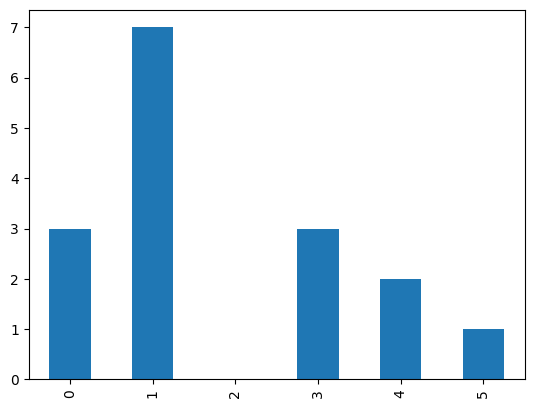

In [213]:
real_labels.plot(kind='bar')

<Axes: xlabel='prediction'>

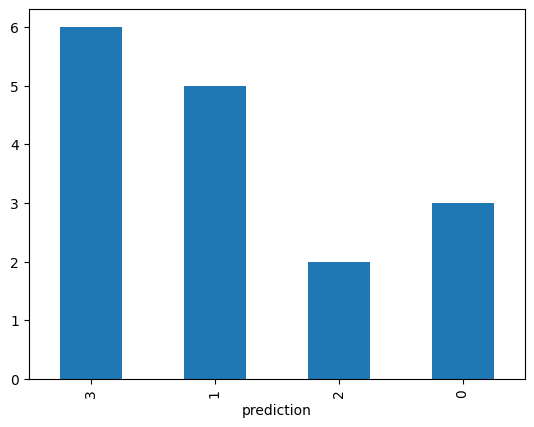

In [194]:
annotation_df['prediction'].value_counts(sort=False).plot(kind='bar')